<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/TimeSeries_AAPL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


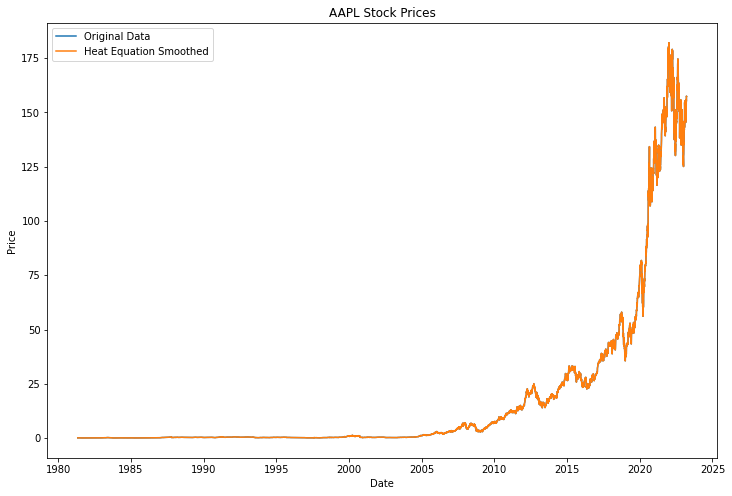

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import yfinance as yf
from scipy.signal import savgol_filter
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

@nb.jit(nopython=True)
def explicit_heat_smooth(prices: np.array, t_end: float = 3.0) -> np.array:
    '''
    Smoothen out a time series using a simple explicit finite difference method.
    The scheme uses a first-order method in time, and a second-order centred
    difference approximation in space. The scheme is only numerically stable
    if the time-step 0<=k<=1.
    
    The prices are fixed at the end-points, so the interior is smoothed.
    Parameters
    ----------
    prices : np.array
        The price to smoothen
    t_end : float
        The time at which to terminate the smoothing (i.e. t = 2)
        
    Returns
    -------
    P : np.array
        The smoothed time-series
    '''
    k = 0.1 # Time spacing
    
    # Set up the initial condition
    P = prices
    
    t = 0
    while t < t_end:
        # Solve the finite difference scheme for the next time-step
        P = k * (P[2:] + P[:-2]) + P[1:-1] * (1 - 2 * k)
        
        # Add the fixed boundary conditions since the above solves the interior
        # points only
        P = np.hstack((
            np.array([prices[0]]),
            P,
            np.array([prices[-1]]),
        ))
        t += k

    return P


def smooth_heat(vals_to_smooth: np.array):
    for n in range(vals_to_smooth.shape[0]):
        vals_to_smooth[n, :] = explicit_heat_smooth(
            vals_to_smooth[n, :],
            t_end=3,
        )
    return vals_to_smooth


def savgol_smooth(vals_to_smooth: np.array):
    for n in range(vals_to_smooth.shape[0]):
        vals_to_smooth[n, :] = savgol_filter(vals_to_smooth[n, :], 11, 5)
    return vals_to_smooth


def get_time_series(df, col, name, lags):
    '''
    Get a time series of data and place them as new cols
    '''
    df = df.copy()  # make a copy to avoid modifying the original DataFrame
    df[f'{name}_t'] = df[col]  # add the current values as a new column
    return df.assign(**{
        f'{name}_t-{lag}': df[col].shift(lag)
        for lag in lags
    })


if __name__ == '__main__':
    df = yf.download('AAPL')
    df = (
        get_time_series(df, 'Close', 'close', range(100))
        .dropna()
        .drop(columns=['Open', 'Low', 'High', 'Close', 'Adj Close', 'Volume'])
    )
    vals_to_smooth = df.values
    heat_eqn = smooth_heat(vals_to_smooth)
    savgol_eqn
    
import matplotlib.pyplot as plt

# Plot the original and smoothed data
plt.figure(figsize=(12,8))
plt.plot(df.index, df['close_t'], label='Original Data')
plt.plot(df.index, heat_eqn[:,0], label='Heat Equation Smoothed')
#plt.plot(df.index, savgol_eqn[:,0], label='Savitzky-Golay Filter Smoothed')
plt.title('AAPL Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
